In [1]:
import os
from pathlib import Path
import sys

if "__project_dir__" not in globals():
    __project_dir__ = Path.cwd().parents[1].resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [54]:
import numpy as np
from numpy import ndarray
from matplotlib import pyplot as plt
import pandas as pd
from pandas import DataFrame
import tidytcells as tt
import json
from cvxpy import Variable, Problem, Minimize, atoms

In [3]:
data_dir = Path("/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data")
raw_data_dir = data_dir/"raw"/"gdb"
processed_data_dir = data_dir/"preprocessed"/"gdb"

### Load and clean data

In [4]:
raw = pd.read_csv(raw_data_dir/"gdb_20230606.csv")

In [5]:
raw_human = raw[raw["meta:tcr_species"] == "HomoSapiens"].copy()

In [6]:
for tr_col in ("TRAV", "TRAJ", "TRBV", "TRBJ"):
    raw_human[tr_col] = raw_human[tr_col].map(lambda x: None if type(x) != str else tt.tcr.standardize(x, enforce_functional=True))
    raw_human[tr_col] = raw_human[tr_col].map(lambda x: None if type(x) != str or not tr_col in x else x)

for cdr3_col in ("CDR3A", "CDR3B"):
    raw_human[cdr3_col] = raw_human[cdr3_col].map(lambda x: None if type(x) != str else tt.junction.standardize(x, strict=True))

/home/yutanagano/Projects/tcr_embedder/.venv/lib/python3.11/site-packages/tidytcells/_utils/warnings.py:12: UserWarning: Failed to standardize "TRAV15" for species homosapiens: gene has no functional alleles. Attempted fix: "TRAV15".
  warn(
/home/yutanagano/Projects/tcr_embedder/.venv/lib/python3.11/site-packages/tidytcells/_utils/warnings.py:12: UserWarning: Failed to standardize "TRAV28" for species homosapiens: gene has no functional alleles. Attempted fix: "TRAV28".
  warn(
/home/yutanagano/Projects/tcr_embedder/.venv/lib/python3.11/site-packages/tidytcells/_utils/warnings.py:12: UserWarning: Failed to standardize "TRAV8-5*01" for species homosapiens: nonfunctional allele. Attempted fix: "TRAV8-5*01".
  warn(
/home/yutanagano/Projects/tcr_embedder/.venv/lib/python3.11/site-packages/tidytcells/_utils/warnings.py:12: UserWarning: Failed to standardize "TRAV33*01" for species homosapiens: nonfunctional allele. Attempted fix: "TRAV33*01".
  warn(
/home/yutanagano/Projects/tcr_embedder

### Focus beta chain data

In [7]:
beta_raw_human = raw_human.dropna(subset=["TRBV", "CDR3B", "Epitope"])
beta_raw_human = beta_raw_human.groupby("Epitope").filter(lambda x: len(x) > 100)

In [8]:
trbvs = sorted(tt.tcr.query(functionality="F", contains="TRBV", precision="gene"))

In [9]:
with open("notebooks/data_processing/trbv_frequencies.json", "r") as f:
    bg_trbv_counts = json.load(f)

In [10]:
bg_trbv_distribution = [bg_trbv_counts[trbv] for trbv in trbvs]
bg_trbv_distribution = np.array(bg_trbv_distribution, dtype=np.float32)
bg_trbv_distribution /= bg_trbv_distribution.sum()

In [11]:
def get_trbv_distribution(data: DataFrame) -> ndarray:
    simplified_trbvs = data.TRBV.map(lambda x: x.split("*")[0])
    trbv_counts = simplified_trbvs.value_counts()
    trbv_counts_vectorised = [trbv_counts[trbv] if trbv in trbv_counts else 0 for trbv in trbvs]
    trbv_counts_vectorised = np.array(trbv_counts_vectorised, dtype=np.float32)
    trbv_frequencies = trbv_counts_vectorised / trbv_counts_vectorised.sum()
    return trbv_frequencies

In [12]:
def get_trbv_distributions_for_all_epitope_groups(data: DataFrame) -> dict:
    epitopes = data.Epitope.unique()

    trbv_distributions = dict()

    for epitope in epitopes:
        epitope_group_data = data[data.Epitope == epitope]
        trbv_distribution = get_trbv_distribution(epitope_group_data)
        trbv_distributions[epitope] = trbv_distribution

    return trbv_distributions

In [13]:
trbv_distributions_for_all_epitope_groups = get_trbv_distributions_for_all_epitope_groups(beta_raw_human)

In [82]:
def investigate_data_partition_strategies():
    target = bg_trbv_distribution.reshape(1,-1)
    #target = np.ones((1,48)) / 48

    all_epitopes = set(beta_raw_human.Epitope.unique())
    baseline_distribution = get_trbv_distribution_for_epitope_selection(all_epitopes)
    baseline_dsitance_from_background = np.linalg.norm((target-baseline_distribution).reshape(-1), ord=1)

    print(f"Baseline distance from background: {baseline_dsitance_from_background}")

    plt.figure()
    plt.bar([2*i for i in range(48)], target.reshape(-1))
    plt.bar([2*i+1 for i in range(48)], baseline_distribution.reshape(-1))
    plt.show()

    for epitope_group_size in (100, 500, 600, 700, 1000):
        filtered_data = beta_raw_human.groupby("Epitope").filter(lambda x: len(x) > epitope_group_size)

        optimal_epitope_selection = get_optimal_epitope_selection(filtered_data, target)

        num_tcrs_in_optimal_selection = calculate_num_tcrs_for_given_epitope_selection(optimal_epitope_selection)
        num_epitopes_in_optimal_selection = len(optimal_epitope_selection)
        trbv_dsitribution = get_trbv_distribution_for_epitope_selection(optimal_epitope_selection)
        distance_from_background = np.linalg.norm((target-trbv_dsitribution).reshape(-1), ord=1)

        print(f"Checking epitope group size: {epitope_group_size}")
        print(f"{num_tcrs_in_optimal_selection} TCRs from {num_epitopes_in_optimal_selection} epitope groups")
        print(f"Distance from background: {distance_from_background}")

        plt.figure()
        plt.bar([2*i for i in range(48)], target.reshape(-1))
        plt.bar([2*i+1 for i in range(48)], trbv_dsitribution.reshape(-1))
        plt.show()


def get_optimal_epitope_selection(data: DataFrame, target: ndarray) -> set:
    epitopes_available = sorted(data.Epitope.unique())
    num_epitopes_available = len(epitopes_available)
    trbv_distributions_per_epitope = [trbv_distributions_for_all_epitope_groups[epitope] for epitope in epitopes_available]
    trbv_distributions_as_matrix = np.stack(trbv_distributions_per_epitope, axis=0)

    variables = Variable((1, num_epitopes_available), integer=True)

    problem = Problem(
        Minimize(
            atoms.norm1((variables @ trbv_distributions_as_matrix) / (num_epitopes_available * 1.0) - target)
        ),
        [variables >= 0, variables <= 1]
    )
    problem.solve()

    results = variables.value
    indices_of_optimal_epitopes = np.nonzero(results)[1]
    optimal_epitopes = [epitopes_available[index] for index in indices_of_optimal_epitopes]

    return set(optimal_epitopes)


def calculate_num_tcrs_for_given_epitope_selection(epitope_selection: set) -> int:
    epitope_group_tcr_counts = beta_raw_human.Epitope.value_counts()
    tcr_counts_for_selected_epitopes = [epitope_group_tcr_counts[epitope] for epitope in epitope_selection]
    minimum_group_size = min(tcr_counts_for_selected_epitopes)
    return len(epitope_selection) * minimum_group_size


def get_trbv_distribution_for_epitope_selection(epitope_selection: set) -> ndarray:
    trbv_distributions_for_epitope_selection = np.array([trbv_distributions_for_all_epitope_groups[epitope] for epitope in epitope_selection])
    return trbv_distributions_for_epitope_selection.mean(axis=0)

Baseline distance from background: 0.5750764608383179


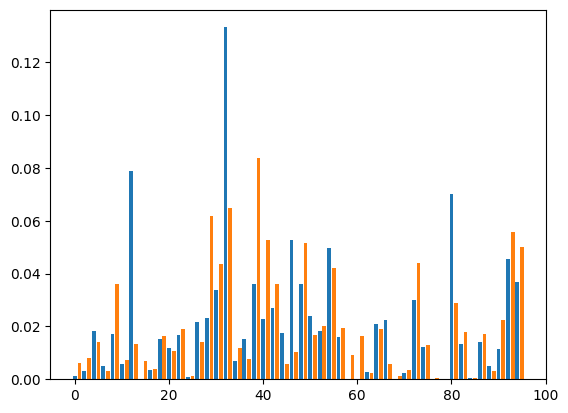

Checking epitope group size: 100
11514 TCRs from 114 epitope groups
Distance from background: 0.4984763562679291


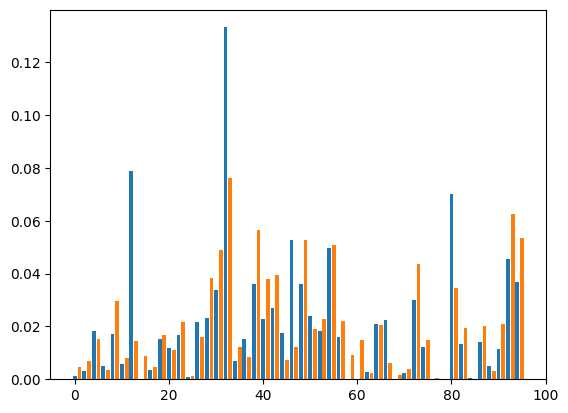

Checking epitope group size: 500
19617 TCRs from 39 epitope groups
Distance from background: 0.5222554206848145


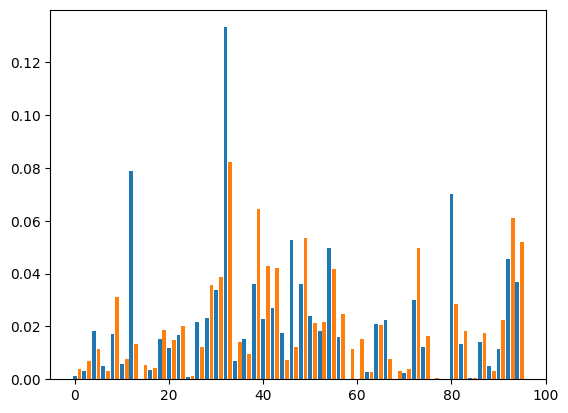

Checking epitope group size: 600
21875 TCRs from 35 epitope groups
Distance from background: 0.5280846953392029


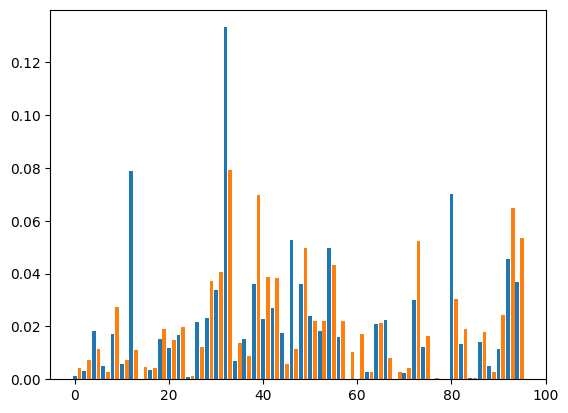

Checking epitope group size: 700
21900 TCRs from 30 epitope groups
Distance from background: 0.5198317170143127


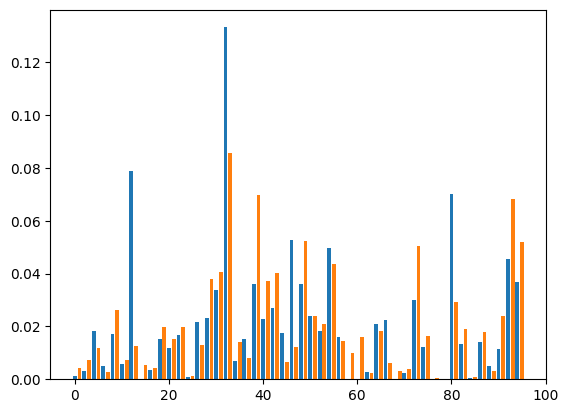

Checking epitope group size: 1000
21040 TCRs from 20 epitope groups
Distance from background: 0.5346329212188721


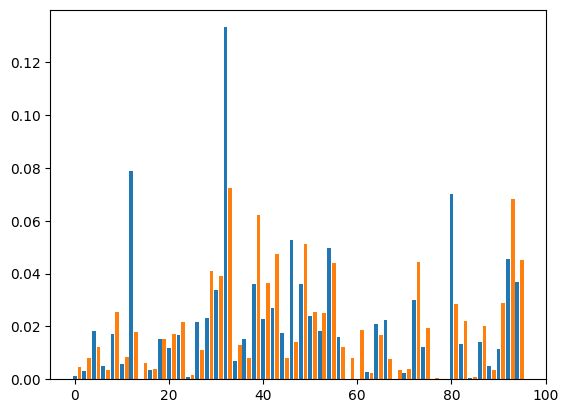

In [83]:
investigate_data_partition_strategies()

In [55]:
MIN_EPITOPE_GROUP_SIZE = 500

In [84]:
beta_raw_human_filtered = beta_raw_human.groupby("Epitope").filter(lambda x: len(x) > MIN_EPITOPE_GROUP_SIZE)
target = bg_trbv_distribution.reshape(1,-1)

epitope_selection = get_optimal_epitope_selection(beta_raw_human_filtered, target)

In [85]:
tcrs_from_selected_epitope_groups = beta_raw_human[beta_raw_human.Epitope.map(lambda x: x in epitope_selection)]
minimum_group_size = tcrs_from_selected_epitope_groups.Epitope.value_counts().min()
selected_tcrs = tcrs_from_selected_epitope_groups.groupby("Epitope").sample(n=minimum_group_size, random_state=420)

In [86]:
hold_out_epitopes = epitope_group_tcr_counts[epitope_group_tcr_counts > 200][-20:].index.to_list()

In [87]:
assert not set(hold_out_epitopes).intersection(epitope_selection)

In [88]:
default_holdout = beta_raw_human[beta_raw_human.Epitope.isin(hold_out_epitopes)]
default_train = beta_raw_human[~beta_raw_human.index.isin(default_holdout.index)]

In [89]:
default_holdout = default_holdout.groupby("Epitope").sample(n=200, random_state=420)

In [90]:
top_20_epitopes = default_train.Epitope.value_counts()[:20].index

In [91]:
default_valid = default_train[default_train.Epitope.isin(top_20_epitopes)].groupby("Epitope").sample(frac=0.1)

In [92]:
default_train = default_train[~default_train.index.isin(default_valid.index)]

In [93]:
selected_tcrs_validation = tcrs_from_selected_epitope_groups[~tcrs_from_selected_epitope_groups.index.isin(selected_tcrs.index)]

In [94]:
minimum_validation_group_size = selected_tcrs_validation.Epitope.value_counts().min()
selected_tcrs_validation = selected_tcrs_validation.groupby("Epitope").sample(n=minimum_validation_group_size, random_state=420)

In [96]:
selected_tcrs_validation.Epitope.nunique()

38

### Save data

In [97]:
default_train.to_csv(processed_data_dir/"train.csv", index=False)
default_valid.to_csv(processed_data_dir/"valid.csv", index=False)
default_holdout.to_csv(processed_data_dir/"test.csv", index=False)

selected_tcrs.to_csv(processed_data_dir/"selected_tcrs_train.csv", index=False)
selected_tcrs_validation.to_csv(processed_data_dir/"selected_tcrs_validation.csv", index=False)

In [98]:
beta_raw_human.to_csv(data_dir/"preprocessed"/"gdb"/"beta_raw_human.csv", index=False)